# Energy loss of protons traversing a medium

## How protons deliver dose

Protons deliver dose by interacting with matter. There are four mechanisms:

1. **Inelastic coulomb interaction with electrons**: positively charged protons passing through matter are dragged by negatively charged electrons. This creates 'friction', which leads to energy loss of the proton and ionisation of the matter.  These interactions are described by the "Vavilov energy straggling distribution".
2. **Elastic coulomb collission with nuclei**: protons passing close to an atomic nucleus are repulsed by electrons and change course. This scattering is described by a Moliere distribution. 
3. **Inelastic nuclear reactions**: when a proton collides with a nucleus and secondary particles are emitted. This energy loss is an empirical formula based on experimental data [PTRAN]. 
4. **Bremstrahlung**: the release of a photon when a proton loses kinetic energy. This is typically ignored in proton therapy, since this only play a role in very high energy protons. 

However, most sources mention that only the first is relevant to compute the stopping power of a proton during radiation therapy. 

## Energy loss rate of ions (linear stopping power)

The energy loss or linear stopping power for a _beam_ of protons (not a single particle and regardless of the mechanism involved) is defined as reduction of beam Energy (E) over distance (x):

$$
S = -\frac{dE}{dx}
$$

### Bragg-Kleeman approximation
The Bragg-Kleeman (1905) rule is an empirical fit that approximates the solution for dE/dX based on parameters $\alpha$ and $x$

$$
-\frac{dE}{\rho dx} \approx -\frac{E_i^{1-p}}{\rho \alpha p}
$$

Note that here the stopping power is divided over the material density $\rho$. This is also how the PSTAR data is presented. 
with range

$$
R \rho^{-1} = \rho^{-1} \alpha E_i^p
$$

with $\alpha$ a material-dependent constant, $p$ a constant that takes into account the dependence on the energy of the beam and $E_i$ the initial energy of the proton beam. The constants $\alpha$ and $p$ must be fitted or obtained from data, e.g. the [PSTAR dataset](https://dx.doi.org/10.18434/T4NC7P). 


In [5]:
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.optimize import minimize
from matplotlib import ticker

# Gobal options.
plt.rcParams['font.family'] = 'serif'
# bragg differential, which should give the 'bragg curve" (?)
dEdx_bragg = lambda Ei, a, p: Ei**(1-p)/(a*p)  # note it this is negative stopping power!
range_bragg = lambda Ei, a, p: a*Ei**p

# Parse data
def PSTAR(material="H"):
    with open(f"../data/pstar{material}.dat", "r") as f:
        lines = [line.strip() for line in f]
        data = np.loadtxt(lines, delimiter=' ', skiprows=8)
    return data
    
# Fit bragg function to data 
# Note: after visual inspection, the function seems to model
# the curve for energies above 0.125 MeV, not below. 
data = PSTAR("H")
datamask = data.T[0]> 0.125
error_func = lambda x: abs(sum(dEdx_bragg(data.T[0, datamask], x[0]*0.001, x[1]) - data.T[3, datamask]))
x0 =  [1.12,1.77]  # initial guess
res = minimize(error_func,x0)

# Print the result of the fit
print(f"Fitted parameters for Hydrogen: a={res.x[0]*0.001:0.5f}, p = {res.x[1]:.2f}")


Fitted parameters for Hydrogen: a=0.00083, p = 1.78


Let's plot the result of our fit. Note that we fit only on the range above 0.125 MeV. 

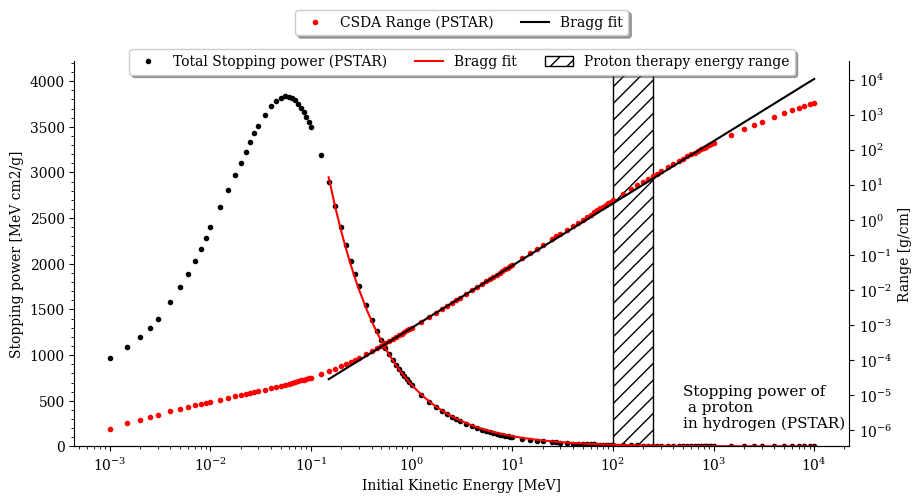

In [7]:
fig, ax = plt.subplots(1, figsize=(10,5))

ax.plot(data.T[0], data.T[3], '.k', label="Total Stopping power (PSTAR)")
ax.plot(data.T[0, datamask], dEdx_bragg(data.T[0, datamask],  res.x[0]*0.001,res.x[1]), '-', color='r', label='Bragg fit')
ax.set_ylim([0, 1.1*max(data.T[3])])

# Plot proton therapy application range
ax.fill_betweenx([0, 1.1*max(data.T[3])], 100, 250, 
                 hatch="//",
                 edgecolor='k', 
                 facecolor="white", 
                 label="Proton therapy energy range")

# plot range on a secondary axis

ax2 = ax.twinx()
ax2.plot(data.T[0], data.T[4], '.r', label="CSDA Range (PSTAR)")
ax2.plot(data.T[0, datamask], range_bragg(data.T[0, datamask], res.x[0]*0.001,res.x[1]), color='k', label="Bragg fit")

# Set plot scale & labels
# Remove axis lines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax.set_xscale('log')
ax2.set_yscale('log')
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))


ax.set_xlabel('Initial Kinetic Energy [MeV]')
ax.set_ylabel('Stopping power [MeV cm2/g]')
ax2.set_ylabel('Range [g/cm]')

# Title.
ax.text(500, 200, "Stopping power of\n a proton\nin hydrogen (PSTAR)", size=11)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
ax2.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

